In [300]:
import numpy as np
from tifffile import imread, imsave, imwrite
from glob import glob
import random
import tqdm
from matplotlib import pyplot as plt
import matplotlib
from sklearn.feature_extraction import image
import cv2

import tensorflow as tf
from tensorflow.data import Dataset
import os

In [301]:
def plot(i, img, lbl, mode):
    img_, lbl_ = img[i], lbl[i]
    plt.figure(figsize=(16,10))
    plt.subplot(121); plt.imshow(img_,cmap='gray');   plt.axis('off'); plt.title(f'Raw image {mode}')
    plt.subplot(122); plt.imshow(lbl_);   plt.axis('off'); plt.title(f'Mask image {mode}')
    plt.show()
    print(np.min(img_),np.max(img_))
    print(np.min(lbl_),np.max(lbl_))

In [302]:
dataset_name = 'g123'
default_dir = './data/patches/'
img_dir = './data/b2u_g123_first/'
label_dir = './data/cvat_g123/'

train_dir = os.path.join(default_dir, 'train/')
test_dir = os.path.join(default_dir, 'test/')


len_test = 3
len_val = 30
patch_size = (768, 768)
max_patches = 50

os.makedirs(default_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [303]:
img_files = sorted(os.listdir(img_dir))
label_files = sorted(os.listdir(label_dir))

In [304]:
img_files

['Tile_001-001-000_0-000.png',
 'Tile_001-002-000_0-000.png',
 'Tile_001-003-000_0-000.png',
 'Tile_001-004-000_0-000.png',
 'Tile_001-005-000_0-000.png',
 'Tile_001-006-000_0-000.png',
 'Tile_001-007-000_0-000.png',
 'Tile_001-008-000_0-000.png',
 'Tile_001-009-000_0-000.png',
 'Tile_001-010-000_0-000.png',
 'Tile_001-011-000_0-000.png',
 'Tile_001-012-000_0-000.png',
 'Tile_001-013-000_0-000.png',
 'Tile_001-014-000_0-000.png',
 'Tile_001-015-000_0-000.png']

In [305]:
# Creating test images
ind = random.sample(range(len(img_files)), len_test)
test_imgs = []

for i in ind:
    img_test_path = os.path.join(img_dir, img_files[i])
    if os.path.isfile(img_test_path) == False:
        raise Exception(f"There are not a file for img {img_files[i]}")
    test_imgs.append(img_test_path)

X_test = np.array([cv2.imread(test_imgs[i], 0) for i in range(len_test)])

In [306]:
imgs = []
labels = []

for img in img_files:

    img_path = os.path.join(img_dir, img)
    if os.path.isfile(img_path) == False:
        raise Exception(f"There are not a file for img {img}")
    imgs.append(img_path)

for label in label_files:

    label_path = os.path.join(label_dir, label)
    if os.path.isfile(label_path) == False:
        raise Exception(f"There are not a file for img {label}")
    labels.append(label_path)

imgs = sorted(imgs)
labels = sorted(labels)

In [307]:
imgs

['./data/b2u_g123_first/Tile_001-001-000_0-000.png',
 './data/b2u_g123_first/Tile_001-002-000_0-000.png',
 './data/b2u_g123_first/Tile_001-003-000_0-000.png',
 './data/b2u_g123_first/Tile_001-004-000_0-000.png',
 './data/b2u_g123_first/Tile_001-005-000_0-000.png',
 './data/b2u_g123_first/Tile_001-006-000_0-000.png',
 './data/b2u_g123_first/Tile_001-007-000_0-000.png',
 './data/b2u_g123_first/Tile_001-008-000_0-000.png',
 './data/b2u_g123_first/Tile_001-009-000_0-000.png',
 './data/b2u_g123_first/Tile_001-010-000_0-000.png',
 './data/b2u_g123_first/Tile_001-011-000_0-000.png',
 './data/b2u_g123_first/Tile_001-012-000_0-000.png',
 './data/b2u_g123_first/Tile_001-013-000_0-000.png',
 './data/b2u_g123_first/Tile_001-014-000_0-000.png',
 './data/b2u_g123_first/Tile_001-015-000_0-000.png']

## Подбираем цвет

In [308]:
image_4cl_dir = './data/cvat_g123'
test_image = cv2.imread(os.path.join(image_4cl_dir, os.listdir(image_4cl_dir)[1]),0)

mask_colors = np.unique(test_image)
print(f'mask colors: {mask_colors}')
print(f'Number of classes {len(mask_colors)}')

mask colors: [  0  81 113 205]
Number of classes 4


Check that colors show according to legend:
"background" : "black",
"holes" : "blue",
"borders" : "red",
"bad_structures" : "yellow"


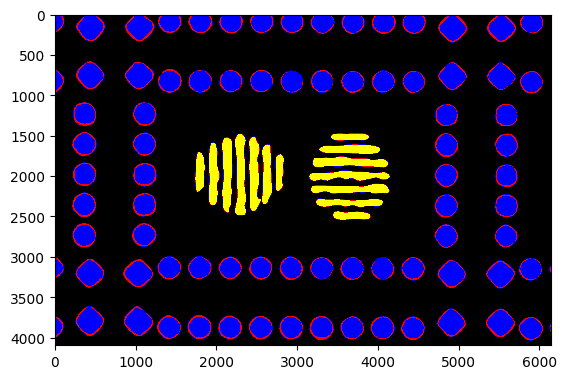

In [309]:
rgb_to_index = {
    mask_colors[0]:0,
    mask_colors[3]:1,
    mask_colors[2]:2,
    mask_colors[1]:3,}

# Legend
index_to_legend = {
    0 : 'background',
    1 : 'holes',
    2 : 'borders',
    3 : 'bad_structures'
}

#Проверка, что для всех цветов из маски сопоставили индекс
if len(mask_colors) != len(rgb_to_index):
    raise Exception(f'len(mask_colors) != len(rgb_to_legend), {len(mask_colors)} != {len(rgb_to_legend)}')


mask = np.zeros_like(test_image)

for i in rgb_to_index.keys():
    mask[test_image == i] = rgb_to_index[i]


mask_cmap = matplotlib.colors.ListedColormap(['black', 'blue', 'red', 'yellow'])
print('Check that colors show according to legend:\n"background" : "black",\n"holes" : "blue",\n"borders" : "red",\n"bad_structures" : "yellow"')
plt.imshow(mask, cmap=mask_cmap )

In [310]:
def change_rgb(patch):
    mask = np.zeros_like(patch)

    for i in rgb_to_index.keys():
        mask[patch == i] = rgb_to_index[i]

    return mask

In [311]:
# Extracting and savinng patches

imgs_patches = []
labels_patches = []

for lab in labels:
    lab_ = change_rgb(cv2.imread(lab, 0))
    patchesmasks = image.extract_patches_2d(lab_, patch_size=patch_size, max_patches=max_patches, random_state=42)

    for j in range(patchesmasks.shape[0]):
        labels_patches.append(patchesmasks[j])

for img in imgs:
    img_ = cv2.imread(img, 0)
    patchesimgs = image.extract_patches_2d(img_, patch_size=patch_size, max_patches=max_patches, random_state=42)
    
    for j in range(patchesimgs.shape[0]):
        imgs_patches.append(patchesimgs[j])

In [315]:
print(np.unique(labels_patches[123]))
print(mask_colors)

[0 1 2]
[  0  81 113 205]


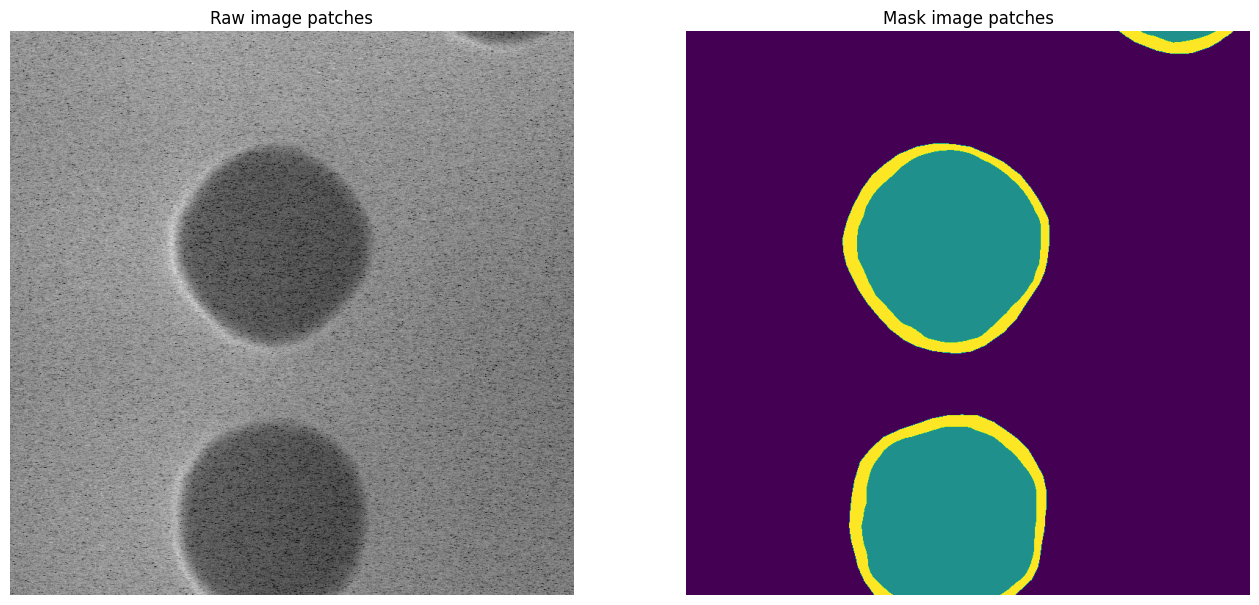

0 149
0 2


In [316]:
plot(123, imgs_patches, labels_patches, 'patches')

ind val: [0, 9, 18, 21, 26, 28, 37, 38, 42, 54, 59, 66, 68, 70, 77, 78, 79, 83, 91, 96, 112, 116, 119, 123, 128, 132, 137, 138, 141, 145]


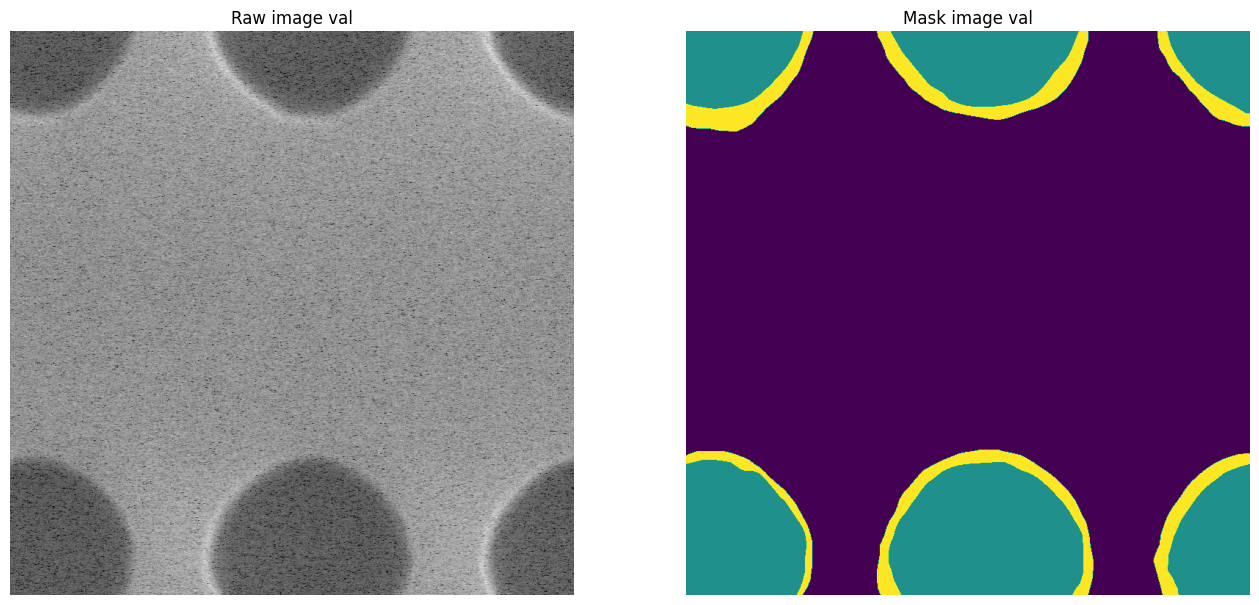

0 149
0 2


In [317]:
# Split the train data
ind_val = sorted(random.sample(range(len(labels_patches)), len_val))
print(f'ind val: {ind_val}')
X_val = [imgs_patches[i] for i in ind_val]
Y_val = [labels_patches[i] for i in ind_val[:5]]

plot(0, X_val, Y_val, 'val')

# plot(27, X_train, Y_train, 'train')

In [318]:
ind_x_train = np.setdiff1d(np.arange(len(imgs_patches)), ind_val)
ind_y_train = np.setdiff1d(np.arange(len(labels_patches)), ind_val)


X_train = [imgs_patches[i] for i in sorted(ind_x_train)]
Y_train = [labels_patches[i] for i in sorted(ind_y_train)]

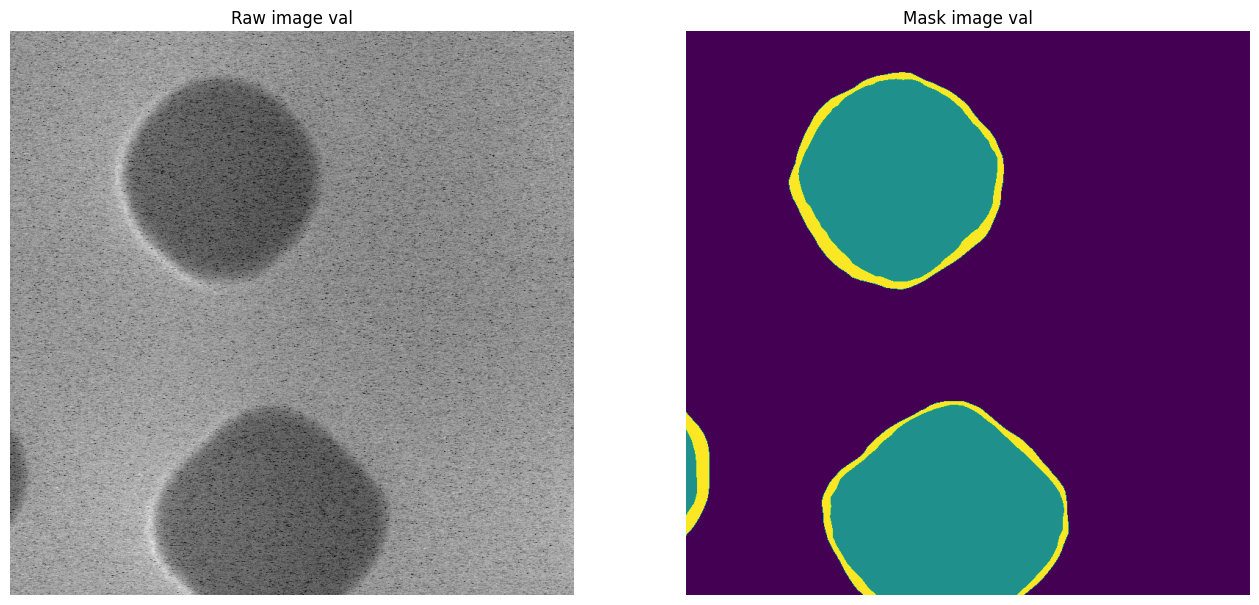

0 147
0 2


In [319]:
plot(27, X_train, Y_train, 'val')

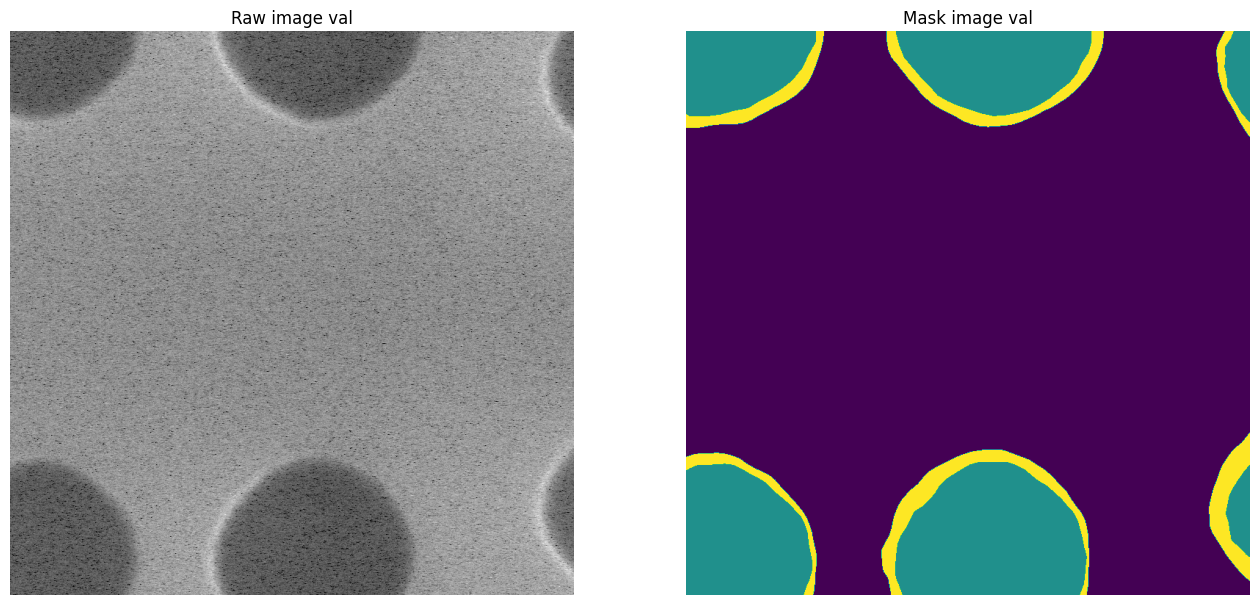

0 153
0 2


In [320]:
plot(11, X_train, Y_train, 'val')

In [321]:
print('- training:       %3d' % len(X_train))
print('- validation:     %3d' % len(X_val))
print('- test:     %3d' % len(X_test))

- training:       720
- validation:      30
- test:       3


In [322]:
os.makedirs(os.path.join(default_dir, f'{dataset_name}/train/labels/'), exist_ok=True)
os.makedirs(os.path.join(default_dir, f'{dataset_name}/train/imgs/'), exist_ok=True)

os.makedirs(os.path.join(default_dir, f'{dataset_name}/val/labels/'), exist_ok=True)
os.makedirs(os.path.join(default_dir, f'{dataset_name}/val/imgs/'), exist_ok=True)

count = 0
for j in range(0, len(Y_train)):
    imwrite(default_dir + f'{dataset_name}/train/labels/' + str(count).zfill(4)+'.tif', Y_train[j])
    count += 1

count = 0
for j in range(0, len(X_train)):
    imwrite(default_dir + f'{dataset_name}/train/imgs/' + str(count).zfill(4)+'.tif', X_train[j])
    count += 1


count = 0
for j in range(0, len(Y_val)):
    imwrite(default_dir + f'{dataset_name}/val/labels/' + str(count).zfill(4)+'.tif', Y_val[j])
    count += 1

count = 0
for j in range(0, len(X_val)):
    imwrite(default_dir + f'{dataset_name}/val/imgs/' + str(count).zfill(4)+'.tif', X_val[j])
    count += 1

In [168]:
import zipfile

def zip_directory(input_dir, output_zip):
    # Ensure the output_zip filename ends with '.zip'
    if not output_zip.lower().endswith('.zip'):
        output_zip += '.zip'

    # Create a ZipFile object in write mode
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the directory tree and add all files and directories to the zip file
        for root, _, files in os.walk(input_dir):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, input_dir))


input_directory = "./data/g123"
output_zipfile = f"./data/{dataset_name}.zip"
zip_directory(input_directory, output_zipfile)

KeyboardInterrupt: 

In [ ]:
# imsave(test_img_dir + X_test_names[i][:-4]+'.tif', X_test[i])
# imsave(test_gt_dir + Y_test_names[i][:-4]+'.tif', Y_test[i])